In [13]:
import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import models
import utils as ut
from models import AEBase, Predictor, PretrainedPredictor

import scanpypip.preprocessing as pp
import scanpypip.utils as scut 

import scanpy as sc

In [14]:
class Arguments:
    def __init__(self):   
        self.epochs = 500
        self.bottleneck = 512
        self.missing_value = np.nan
        self.data_path = "data/GSE108394/GSM2897334/"
        self.test_size = 0.2
        self.valid_size = 0.2
        self.model_store_path = "saved/models/"
        self.logging_file = "saved/logs/"
        self.batch_size = 200
        self.ft_h_dims = "512,256"
        self.var_genes_disp = 0
        self.pretrain_path = "saved/models/"
        self.min_n_genes = 0
        self.max_n_genes = 20000
        self.min_g = 200
        self.min_c = 3

        
args = Arguments()

In [15]:
epochs = args.epochs
dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
na = args.missing_value
data_path = args.data_path
test_size = args.test_size
valid_size = args.valid_size
g_disperson = args.var_genes_disp
min_n_genes = args.min_n_genes
max_n_genes = args.max_n_genes
model_path = args.model_store_path
pretrain_path = args.pretrain_path
log_path = args.logging_file
batch_size = args.batch_size
encoder_hdims = args.ft_h_dims.split(",")
encoder_hdims = list(map(int, encoder_hdims))


In [16]:
now=time.strftime("%Y-%m-%d-%H-%M-%S")
log_path = log_path+now+".txt"
export_name = data_path.replace("/","")
pretrain_path = "saved/models/ae_"+export_name+now+".pkl"

In [17]:
scv = pd.read_csv('data/GSE117872/GSE117872_good_Data_cellinfo.txt',sep="\t")

In [18]:
#scv.shape

In [19]:
adata = pp.read_sc_file('data/GSE117872/GSE117872_good_Data_TPM.txt')

In [20]:
scv

,groups,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8
0,RHC6558,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
1,RHC6559,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
2,RHC6560,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
3,RHC6561,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
4,RHC6562,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
...,...,...,...,...,...,...,...,...,...
1297,RHH3298,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1298,RHH3299,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1299,RHH3300,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1300,RHH3301,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3


In [21]:
adata

AnnData object with n_obs × n_vars = 1302 × 22744

In [22]:
# adata = sc.read_10x_mtx(
#  'data/GSE108394/GSM2897334/',  # the directory with the `.mtx` file 
#  var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#  cache=True)                              # write a cache file for faster subsequent reading


In [23]:
adata

AnnData object with n_obs × n_vars = 1302 × 22744

In [24]:
#adata = sc.pp.filter_cells(adata, min_genes=200)
#adata = sc.pp.filter_genes(adata, min_cells=3)

adata =pp.cal_ncount_ngenes(adata)

In [26]:
# sc.pl.violin(adata, ['n_counts',"percent_mito",'percent_rps', 'percent_rpl'],
#              jitter=0.4, multi_panel=True,save=export_name)

In [27]:
adata = pp.receipe_my(adata,l_n_genes=min_n_genes,r_n_genes=max_n_genes,filter_mincells=args.min_c,
                      filter_mingenes=args.min_g,normalize=True,log=True)

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


(1302, 18120)


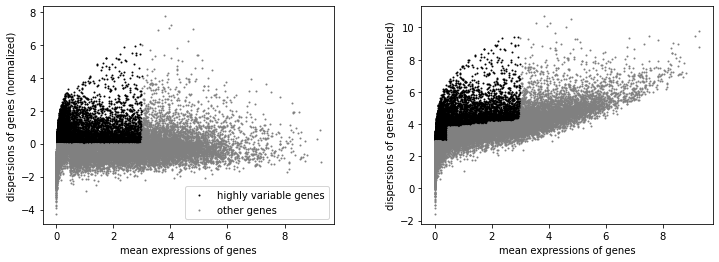

In [28]:
sc.pp.highly_variable_genes(adata,min_disp=g_disperson,max_disp=np.inf)

sc.pl.highly_variable_genes(adata,save=export_name)

In [29]:
adata.raw = adata

adata = adata[:, adata.var.highly_variable]

data=adata.X

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [30]:
data

ArrayView([[0.       , 0.       , 0.       , ..., 0.       , 4.336317 ,
            0.       ],
           [0.       , 1.9343252, 0.       , ..., 0.       , 3.5902724,
            0.       ],
           [0.       , 1.6058226, 0.       , ..., 0.       , 0.       ,
            0.       ],
           ...,
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 1.7354198, 0.       , ..., 0.       , 1.007341 ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ]], dtype=float32)

In [31]:
mmscaler = preprocessing.MinMaxScaler()

In [32]:
data = mmscaler.fit_transform(data)

In [33]:
X_train, X_valid = train_test_split(data, test_size=valid_size, random_state=42)

In [34]:
print(X_train.shape, X_valid.shape)

(1041, 5781) (261, 5781)


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

# Construct datasets and data loaders
X_trainTensor = torch.FloatTensor(X_train).to(device)
X_validTensor = torch.FloatTensor(X_valid).to(device)
X_allTensor = torch.FloatTensor(data).to(device)

train_dataset = TensorDataset(X_trainTensor, X_trainTensor)
valid_dataset = TensorDataset(X_validTensor, X_validTensor)
all_dataset = TensorDataset(X_allTensor, X_allTensor)


X_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
X_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

dataloaders_pretrain = {'train':X_trainDataLoader,'val':X_validDataLoader}


cuda:0


In [36]:
len(X_trainDataLoader)

6

In [37]:
encoder = AEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims)
#model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    encoder.cuda()

print(encoder)
encoder.to(device)
optimizer_e = optim.Adam(encoder.parameters(), lr=1e-2)
loss_function_e = nn.MSELoss()
exp_lr_scheduler_e = lr_scheduler.ReduceLROnPlateau(optimizer_e)
encoder,loss_report_en = ut.train_extractor_model(net=encoder,data_loaders=dataloaders_pretrain,
                            optimizer=optimizer_e,loss_function=loss_function_e,
                            n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=pretrain_path)

print("Pretrained finished")

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5781, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=512, out_features=5781, bias=True)
    (1): Sigmoid()
  )
)
Epo

train Loss: 0.00010500. Learning rate = 0.001
val Loss: 0.00013537. Learning rate = 0.001
Epoch 65/499
----------
train Loss: 0.00010369. Learning rate = 0.001
val Loss: 0.00013709. Learning rate = 0.001
Epoch 66/499
----------
train Loss: 0.00010473. Learning rate = 0.001
val Loss: 0.00013441. Learning rate = 0.001
Epoch 67/499
----------
train Loss: 0.00010512. Learning rate = 0.001
val Loss: 0.00013525. Learning rate = 0.001
Epoch 68/499
----------
train Loss: 0.00010456. Learning rate = 0.001
val Loss: 0.00013558. Learning rate = 0.001
Epoch 69/499
----------
train Loss: 0.00010457. Learning rate = 0.001
val Loss: 0.00013599. Learning rate = 0.001
Epoch 70/499
----------
train Loss: 0.00010438. Learning rate = 0.001
val Loss: 0.00013599. Learning rate = 0.001
Epoch 71/499
----------
train Loss: 0.00010580. Learning rate = 0.001
val Loss: 0.00013475. Learning rate = 0.001
Epoch 72/499
----------
train Loss: 0.00010453. Learning rate = 0.001
val Loss: 0.00013730. Learning rate = 0.00

train Loss: 0.00010458. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013443. Learning rate = 1.0000000000000002e-07
Epoch 132/499
----------
train Loss: 0.00010411. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013373. Learning rate = 1.0000000000000002e-07
Epoch 133/499
----------
train Loss: 0.00010497. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013501. Learning rate = 1.0000000000000002e-07
Epoch 134/499
----------
train Loss: 0.00010478. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013487. Learning rate = 1.0000000000000002e-07
Epoch 135/499
----------
train Loss: 0.00010348. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013415. Learning rate = 1.0000000000000002e-07
Epoch 136/499
----------
train Loss: 0.00010344. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013628. Learning rate = 1.0000000000000002e-07
Epoch 137/499
----------
train Loss: 0.00010375. Learning rate = 1.0000000000000002e-07
val Loss: 0.00013718. Learning rate = 1.000

train Loss: 0.00010475. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013512. Learning rate = 1.0000000000000004e-08
Epoch 188/499
----------
train Loss: 0.00010603. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013433. Learning rate = 1.0000000000000004e-08
Epoch 189/499
----------
train Loss: 0.00010405. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013549. Learning rate = 1.0000000000000004e-08
Epoch 190/499
----------
train Loss: 0.00010380. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013271. Learning rate = 1.0000000000000004e-08
Epoch 191/499
----------
train Loss: 0.00010430. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013468. Learning rate = 1.0000000000000004e-08
Epoch 192/499
----------
train Loss: 0.00010476. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013483. Learning rate = 1.0000000000000004e-08
Epoch 193/499
----------
train Loss: 0.00010447. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013446. Learning rate = 1.000

train Loss: 0.00010531. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013557. Learning rate = 1.0000000000000004e-08
Epoch 244/499
----------
train Loss: 0.00010507. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013478. Learning rate = 1.0000000000000004e-08
Epoch 245/499
----------
train Loss: 0.00010446. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013426. Learning rate = 1.0000000000000004e-08
Epoch 246/499
----------
train Loss: 0.00010772. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013369. Learning rate = 1.0000000000000004e-08
Epoch 247/499
----------
train Loss: 0.00010318. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013561. Learning rate = 1.0000000000000004e-08
Epoch 248/499
----------
train Loss: 0.00010504. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013356. Learning rate = 1.0000000000000004e-08
Epoch 249/499
----------
train Loss: 0.00010446. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013299. Learning rate = 1.000

train Loss: 0.00010392. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013415. Learning rate = 1.0000000000000004e-08
Epoch 300/499
----------
train Loss: 0.00010425. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013538. Learning rate = 1.0000000000000004e-08
Epoch 301/499
----------
train Loss: 0.00010430. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013515. Learning rate = 1.0000000000000004e-08
Epoch 302/499
----------
train Loss: 0.00010408. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013562. Learning rate = 1.0000000000000004e-08
Epoch 303/499
----------
train Loss: 0.00010414. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013490. Learning rate = 1.0000000000000004e-08
Epoch 304/499
----------
train Loss: 0.00010391. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013534. Learning rate = 1.0000000000000004e-08
Epoch 305/499
----------
train Loss: 0.00010364. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013526. Learning rate = 1.000

train Loss: 0.00010457. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013640. Learning rate = 1.0000000000000004e-08
Epoch 355/499
----------
train Loss: 0.00010394. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013484. Learning rate = 1.0000000000000004e-08
Epoch 356/499
----------
train Loss: 0.00010453. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013548. Learning rate = 1.0000000000000004e-08
Epoch 357/499
----------
train Loss: 0.00010436. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013401. Learning rate = 1.0000000000000004e-08
Epoch 358/499
----------
train Loss: 0.00010421. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013585. Learning rate = 1.0000000000000004e-08
Epoch 359/499
----------
train Loss: 0.00010421. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013633. Learning rate = 1.0000000000000004e-08
Epoch 360/499
----------
train Loss: 0.00010358. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013487. Learning rate = 1.000

train Loss: 0.00010401. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013493. Learning rate = 1.0000000000000004e-08
Epoch 411/499
----------
train Loss: 0.00010438. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013598. Learning rate = 1.0000000000000004e-08
Epoch 412/499
----------
train Loss: 0.00010399. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013399. Learning rate = 1.0000000000000004e-08
Epoch 413/499
----------
train Loss: 0.00010408. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013529. Learning rate = 1.0000000000000004e-08
Epoch 414/499
----------
train Loss: 0.00010450. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013377. Learning rate = 1.0000000000000004e-08
Epoch 415/499
----------
train Loss: 0.00010364. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013569. Learning rate = 1.0000000000000004e-08
Epoch 416/499
----------
train Loss: 0.00010366. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013579. Learning rate = 1.000

train Loss: 0.00010470. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013529. Learning rate = 1.0000000000000004e-08
Epoch 467/499
----------
train Loss: 0.00010424. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013394. Learning rate = 1.0000000000000004e-08
Epoch 468/499
----------
train Loss: 0.00010446. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013464. Learning rate = 1.0000000000000004e-08
Epoch 469/499
----------
train Loss: 0.00010463. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013518. Learning rate = 1.0000000000000004e-08
Epoch 470/499
----------
train Loss: 0.00010399. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013661. Learning rate = 1.0000000000000004e-08
Epoch 471/499
----------
train Loss: 0.00010391. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013346. Learning rate = 1.0000000000000004e-08
Epoch 472/499
----------
train Loss: 0.00010429. Learning rate = 1.0000000000000004e-08
val Loss: 0.00013587. Learning rate = 1.000

In [38]:
embeddings = encoder.encode(X_allTensor).detach().cpu().numpy()

In [39]:
sc.tl.pca(adata, svd_solver='arpack')

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [40]:
adata.obsm["X_AE"] = embeddings

In [41]:
sc.pp.neighbors(adata, n_neighbors=10,use_rep="X_AE")
#sc.tl.umap(adata)

D:\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [42]:
sc.tl.tsne(adata,use_rep="X_AE")

In [43]:
sc.tl.leiden(adata)

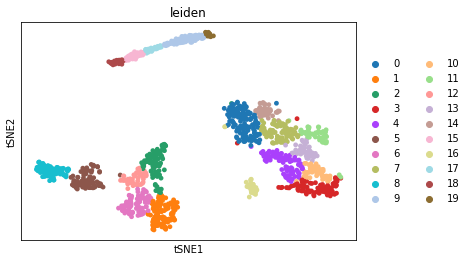

In [44]:
sc.pl.tsne(adata,save=export_name,color=["leiden"])

In [64]:
scv

,groups,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8
0,RHC6558,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
1,RHC6559,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
2,RHC6560,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
3,RHC6561,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
4,RHC6562,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
...,...,...,...,...,...,...,...,...,...
1297,RHH3298,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1298,RHH3299,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1299,RHH3300,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1300,RHH3301,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3


In [66]:
sens = [str(i) for i in scv.cluster]

In [67]:
len(adata.obs["sens"])

1302

In [68]:
adata.obs["sens"] = sens

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sens' as categorical


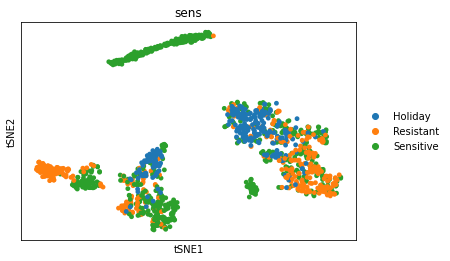

In [69]:
sc.pl.tsne(adata,save=export_name,color=["sens"])

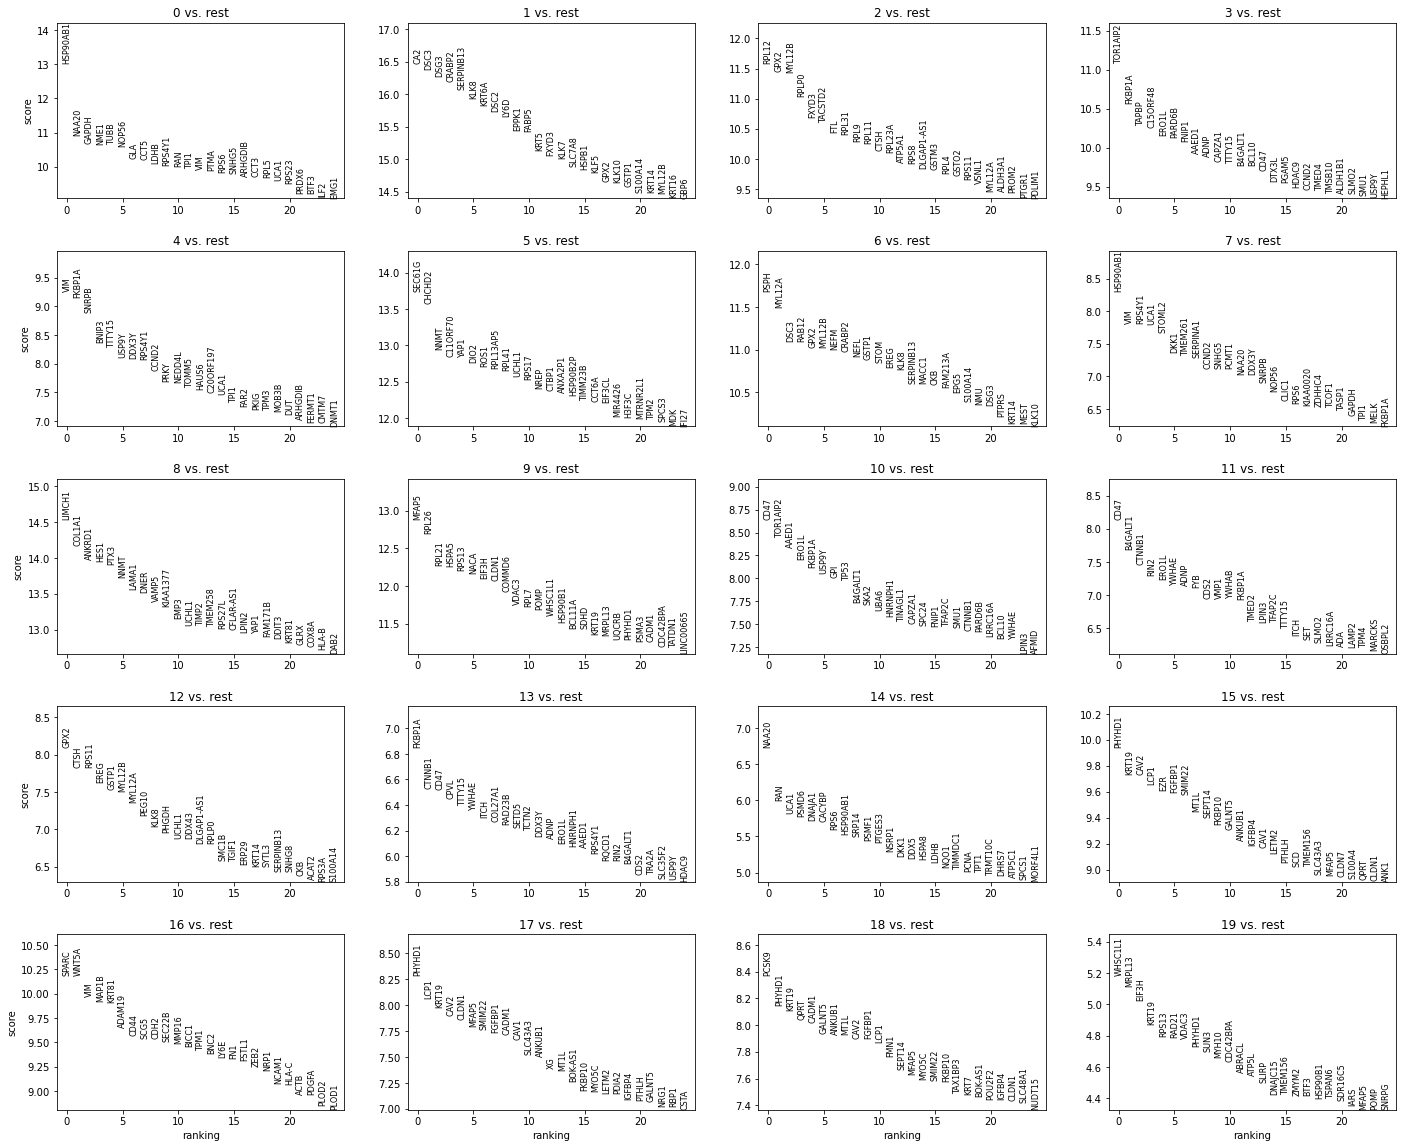

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=export_name)

In [46]:
adata.write("saved/results"+export_name+".h5ad")